# OMIM phenotypes and inheritance modes of constrained genes
Plot the proportion of genes which are associated with an OMIM morbid phenotype. The plot is stratified by region, constraint, and inheritance pattern. 

Note:
- Where a gene is associated with a phenotype or phenotypes with more than one mode of inheritance, it is double-counted. I.e. it is counted separately in each inheritance group.

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Plot colours and themes

In [2]:
sns.set_context("talk")

In [3]:
# Choose the colorblind palette
sns.color_palette("colorblind")

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [4]:
col = sns.color_palette("colorblind").as_hex()

## Data formatting
Reformat the OMIM / constraint annotations so that they are more suitable for plotting

In [5]:
# Read data
df = pd.read_csv("../outputs/omim_phenotypes_in_constrained_regions.tsv", sep="\t")

# Individual phenotypes are converted to True (present) or False (absent)
df["phenotype"] = df["phenotype"].fillna(False)
df.loc[df["phenotype"] != False, "phenotype"] = True

# Limit to relevant columns
df = df[["ensg", "region", "constraint", "phenotype", "inheritance"]]

# Drop duplicates
df = df.drop_duplicates()

# Exclude start-proximal regions, which are uninformative
df = df[df["region"] != "start_proximal"]

print("Region value counts:")
print(df.region.value_counts())

Region value counts:
transcript    12673
distal_nmd    12070
nmd_target     9912
long_exon      1962
Name: region, dtype: int64


## Summary statistics
Calculate the summary statistics necessary for the plot.
- The absolute proportion of genes in each constraint category which are in OMIM, with a given inheritance mode.
- The number of genes in each constraint category

### Format data

In [6]:
# Proportion of constrained genes with a phenotype
_a = df.groupby(["constraint", "region"])["phenotype"].value_counts(normalize=True)

# Inheritance mode for genes with a phenotype
_b = df.groupby(["constraint", "region", "phenotype"])["inheritance"].value_counts(
    normalize=True
)

# Get the absolute proportion for each inheritance mode
df1 = (_a * _b).dropna().rename("abs_proportion")

# Number of unique genes in each region / constraint category
_c = df.groupby(["region", "constraint"])["ensg"].nunique().rename("n")

# Combine absolute proportions and gene counts
df1 = df1.to_frame()  # Allows merging
df1 = df1.merge(_c, left_index=True, right_index=True)  # Add gene counts
df1 = df1.reset_index(drop=False)

# Clean label text
df1 = df1.replace(
    {
        "constrained": "Constrained",
        "unconstrained": "Unconstrained",
        "distal_nmd": "Distal",
        "long_exon": "Long exon",
        "nmd_target": "NMD target",
        "transcript": "Transcript",
    }
)

# Show a sample of the data:
print("Show a sample of the data:")
df1.sample(3)

Show a sample of the data:


,constraint,region,phenotype,inheritance,abs_proportion,n
19,Unconstrained,Distal,True,Other,0.002347,11233
1,Constrained,Distal,True,Autosomal recessive,0.072310,548
14,Constrained,Transcript,True,Other,0.004103,3538


Genes associated with >1 mode of inheritance are double-counted.

### Plot

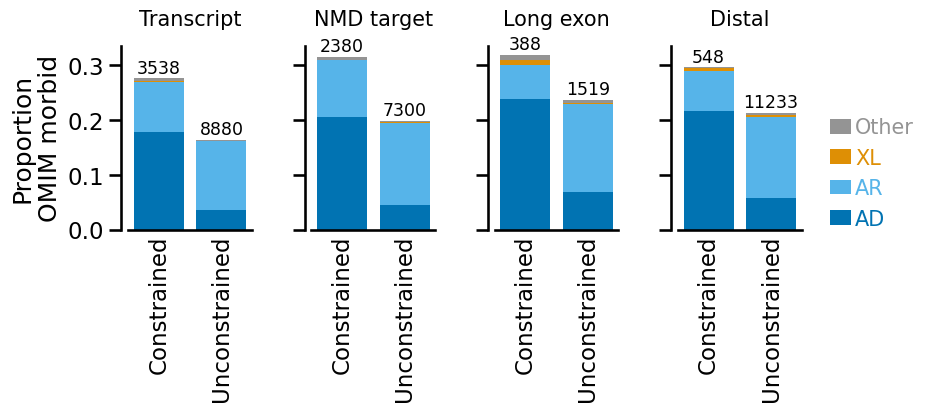

In [24]:
# Specify figure properties
fig, axs = plt.subplots(1, 4, sharey=True, layout="constrained", figsize=(8, 4))

# Define common variables
regions = ["Transcript", "NMD target", "Long exon", "Distal"]
inheritance = df1.inheritance.unique()
colours = [col[0], col[-1], col[1], col[-3]]
ticks = np.arange(df1["constraint"].nunique())  # Two x categories per Axes

# Create the figure by iterating through each Axes
# Each Axes contains a plot for one region.
for ax, r in zip(axs, regions):

    # Subset the data to one region
    d = df1[df1["region"] == r]

    # A stacked bar chart - define the y-axis coordinate of the bottom of the bar
    bottom = np.zeros(len(ticks))

    # For each inheritance mode, add a separate bar to the Axes
    for i, c in zip(inheritance, colours):

        # Subset to one inheritance mode
        _d = d[d["inheritance"] == i]

        # Add the bar(s)
        b = ax.bar(
            x=ticks,
            height=_d["abs_proportion"],
            label=_d["inheritance"],
            color=c,
            bottom=bottom,  # The y-position of the bottom of the bar
        )

        # Stack the bars
        bottom += list(_d["abs_proportion"])

    # Set the properties for all Axes
    ax.set_xticks(
        ticks=ticks,
        labels=_d["constraint"],
        rotation=90,
    )
    ax.tick_params(axis="x", length=0)  # Hide x ticks
    ax.set_yticks(ticks=[0, 0.1, 0.2, 0.3])
    ax.set_title(r, size="small", loc="center", pad=15)
    ax.spines[["top", "right"]].set_visible(False)
    ax.spines["left"].set_position(("outward", 5))

    # Add bar labels
    for i, n in enumerate(_d["n"]):
        y_offset = 0.01
        ax.text(
            x=ticks[i],
            y=bottom[i] + y_offset,
            s=n,
            fontsize="x-small",
            ha="center",
        )

# Set the y label for the left-most Axes only
axs[0].set_ylabel("Proportion\nOMIM morbid")

# Add width whitespace to the figure
fig.get_layout_engine().set(wspace=0.2)

# Figure legend
fig.legend(
    handles=[axs[0].get_children()[x] for x in [0, 2, 4, 6,]][
        ::-1
    ],  # Reverse the order of the handles
    labels=[
        "Other",
        "XL",
        "AR",
        "AD",
    ],  # Custom labels
    fontsize="small",
    frameon=False,
    labelcolor="linecolor",
    loc="lower left",
    bbox_to_anchor=(1.02, 0.42),
    handlelength=1,
    handletextpad=0.2,
    borderaxespad=0,
)

# Save the figure
plt.savefig(
    "../plots/omim_morbid_constrained_regions.svg", format="svg", bbox_inches="tight"
)